In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
price_files = ['ADA-USD.csv', 'AGIX-USD.csv', 'BNB-USD.csv',
               'BTC-USD.csv', 'CAKE-USD.csv', 'DOGE-USD.csv',
               'DOT-USD.csv', 'ETH-USD.csv', 'FET-USD.csv',
               'FIL-USD.csv', 'KCS-USD.csv', 'LINK-USD.csv',
               'LTC-USD.csv', 'OCEAN-USD.csv', 'ROSE-USD.csv', 
               'SOL-USD.csv', 'UNI-USD.csv', 'XMR-USD.csv',
               'XRP-USD.csv', 'XTZ-USD.csv']

## TOKEN MAPPING
trend_to_token_mapping = {
    "bitcoin.csv": "btc",
    "bnb.csv": "bnb",
    "cardano.csv": "ada",
    "chainlink.csv": "link",
    "dogecoin.csv": "doge",
    "ethereum.csv": "eth",
    "fetch.ai.csv": "fet",
    "filecoin.csv": "fil",
    "kucoin.csv": "kcs",
    "litecoin.csv": "ltc",
    "monero.csv": "xmr",
    "oasis network.csv": "rose",
    "ocean protocol.csv": "ocean",
    "pancakeswap.csv": "cake",
    "polkadot.csv": "dot",
    "singularitynet.csv": "agix",
    "solana.csv": "sol",
    "tezos.csv": "xtz",
    "uniswap.csv": "uni",
    "XRP.csv": "xrp"
}


tokens = []

for pair in price_files:
    token = pair.split("-")[0].lower()
    tokens.append(token)


In [3]:
def get_trend(token, mapping):
    for k, v in mapping.items():
        if token == v:
            filename = f'trends/{k}'
            trends_df = pd.read_csv(filename)
            return trends_df
    return f'No Trend for token {token}'

def load_price_data(token, tokens_list, price_files):
    idx = tokens_list.index(token)
    filename = f'prices/{price_files[idx]}'
    return pd.read_csv(filename)
    

In [29]:
def clean_price_data(price_df):
    #Perform an initial check of df
    print(price_df.shape)
    print(price_df.info())
    price_df['Date'] = pd.to_datetime(price_df['Date'])
    price_df['Year'] = pd.to_datetime(price_df['Date']).dt.year
    price_df['Month'] = pd.to_datetime(price_df['Date']).dt.month
    price_df['Day'] = pd.to_datetime(price_df['Date']).dt.day

    # Descibe df 
    print(price_df.describe())
    
    useful_columns = ['Date', 'Close', 'Volume', 'Year', 'Month', 'Day']
    price_df = price_df[useful_columns]
    return price_df

def clean_trend_data(trend_df):
    #Perform an initial check of df
    print(trend_df.shape)
    print(trend_df.info())
    
    trend_df['Week'] = pd.to_datetime(trend_df['Week'])
    trend_df['Year'] = pd.to_datetime(trend_df['Week']).dt.year
    trend_df['Month'] = pd.to_datetime(trend_df['Week']).dt.month

    # Convert count to numeric to avoid non-correlation
    trend_df['count'] = pd.to_numeric(trend_df['count'], errors='coerce')
    trend_df['count'] = trend_df['count'].fillna(1)

    #Describe 
    trend_df.describe()
    return trend_df

def merging_df(price_df, trend_df):
    #Resample data into Weekly data from daily
    weekly_price = price_df.set_index('Date')

    weekly_df = weekly_price.resample('W').agg({'Close': 'last', 'Volume': 'sum', 'Year': 'last', 'Month': 'last', 'Day': 'last'})
    weekly_df.reset_index(inplace=True)

    # Set the timeframe for merging
    week0 = trend_df['Week'][0]

    price_trend = weekly_df[weekly_df['Date']>=week0]
    price_trend.reset_index(inplace=True, drop=True)

    price_trend =  pd.merge(price_trend, trend_df, how='left', left_on='Date', right_on='Week')
    price_trend = price_trend[['Date', 'Close', 'Volume', 'Year_x', 'Month_x', 'count']]
    return price_trend


def correlations(df, token, ax=None):
    correlations = df.corr()
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
    else:
        fig = ax.get_figure()
    sns.heatmap(correlations, annot=True, linewidths=.5, ax=ax, cmap="mako")
    ax.set_title(f'Correlations for {token}')
    fig.tight_layout()
    return ax

def plot_data(price_df, n_cols, token):

    fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(30, 8))
    fig.tight_layout(pad=5.0)

    axes[0].plot(price_df['Date'], price_df['Close'])
    axes[1].plot(price_df['Date'], np.log(price_df['Volume']))
    axes[0].set(xlabel='Date', ylabel='Price (USD)', title=f'{token}-USD Chart')
    axes[1].set(xlabel='Date', ylabel='log(Volume)', title=f'{token}-USD Volume')

    if n_cols == 3:
        axes[2].plot(price_df['Date'], price_df['count'])
        axes[2].set(xlabel='Date', ylabel='Word Count', title=f"{token}'s Google Trend")





(3493, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3493 entries, 0 to 3492
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3493 non-null   object 
 1   Open       3493 non-null   float64
 2   High       3493 non-null   float64
 3   Low        3493 non-null   float64
 4   Close      3493 non-null   float64
 5   Adj Close  3493 non-null   float64
 6   Volume     3493 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 191.1+ KB
None
               Open          High           Low         Close     Adj Close  \
count   3493.000000   3493.000000   3493.000000   3493.000000   3493.000000   
mean   15719.510806  16088.267343  15329.240505  15737.874475  15737.874475   
std    17405.268305  17826.628959  16950.264363  17424.166235  17424.166235   
min      176.897003    211.731003    171.509995    178.102997    178.102997   
25%      998.885010   1031.390015    976.002014   1004.45001

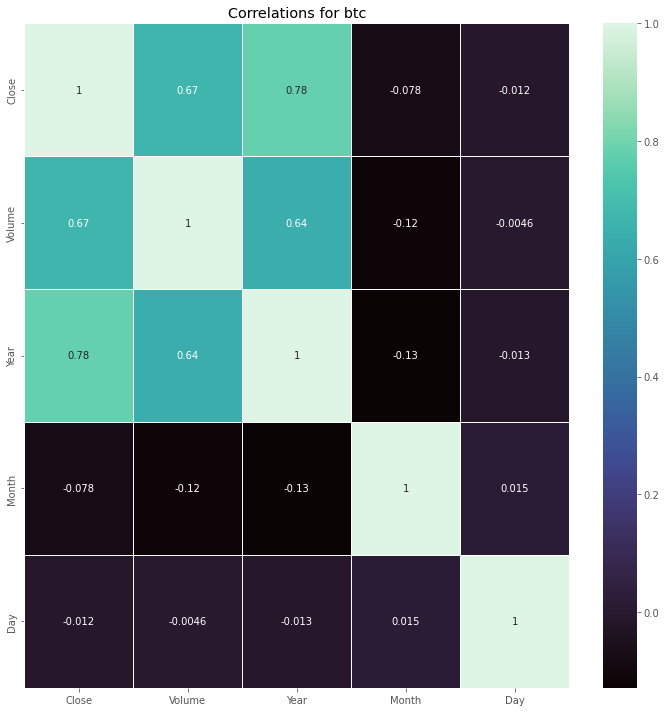

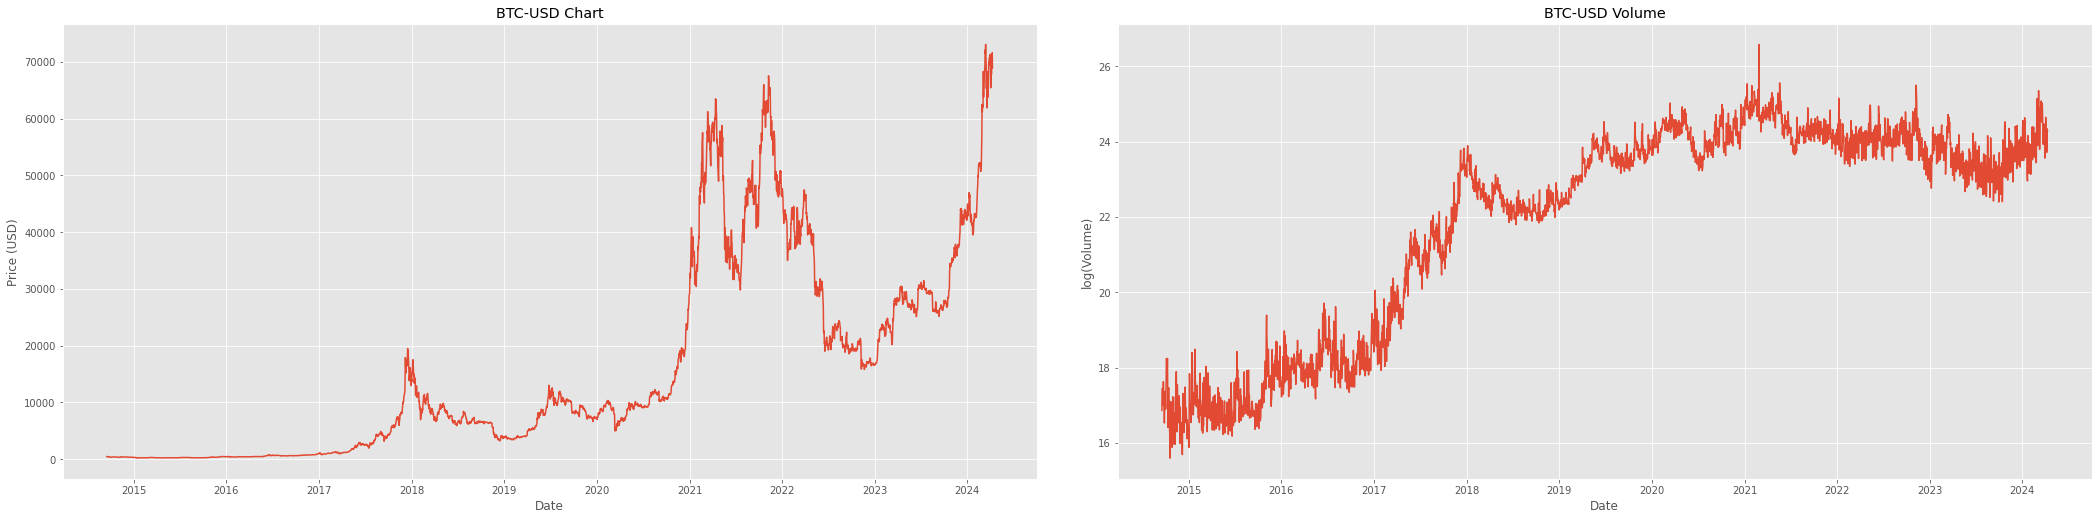

In [30]:

btc_trend = get_trend('btc', trend_to_token_mapping)
btc_price = load_price_data('btc', tokens, price_files)
clean_btc = clean_price_data(btc_price)
clean_trend_btc = clean_trend_data(btc_trend)
btc_df = merging_df(clean_btc, clean_trend_btc)
correlations(clean_btc, 'btc')
plot_data(clean_btc, 2, 'BTC')